In [1]:
import cv2
import time
import imutils

In [2]:
def pyramid(image, scale = 1.5, minisize = (30, 30)):
    yield image
    
    while True:
        
        w = int(image.shape[1] / scale)
        image = imutils.resize(image, width = w)
        if image.shape[0] < minisize[1] or image.shape[1] < minisize[0]:
            break
        yield image

In [3]:
def sliding_window(image, stepSize, windowSize):
    for y in range(0, image.shape[0], stepSize):
        for x in range(0, image.shape[1], stepSize):
            yield(x, y, image[y: y + windowSize[1], x: x + windowSize[0]])

In [4]:
image = cv2.imread('./images_Object_Detection/lena.jpg')

(winW, winH) = (128, 128)

In [5]:
for resized in pyramid(image, scale = 1.5):
    for (x, y, window) in sliding_window(resized, stepSize = 32, windowSize = (winW, winH)):
        if window.shape[0] != winH or window.shape[1] != winH:
            continue
        clone = resized.copy()
        cv2.rectangle(clone, (x, y), (x + winW, y + winH), (0, 255, 0), 2)
        cv2.imshow('Window', clone)
        cv2.waitKey(1)
        time.sleep(0.025)
    cv2.destroyAllWindows()

In [6]:
x = [1, 2]

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import hog
from skimage import data, exposure

In [8]:
image = data.astronaut()

fd, hog_image = hog(image, orientations = 8, pixels_per_cell = (16, 16), cells_per_block = (1, 1), visualize = True, multichannel = True)

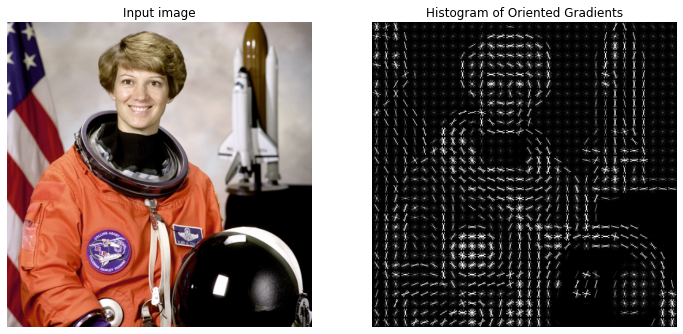

In [9]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (12, 6), sharex = True, sharey = True)

ax1.axis('off')
ax1.imshow(image, cmap = plt.cm.gray)
ax1.set_title('Input image')

hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range = (0, 10))

ax2.axis('off')
ax2.imshow(hog_image_rescaled, cmap = plt.cm.gray)
ax2.set_title('Histogram of Oriented Gradients')
plt.show()

In [10]:
from sklearn.datasets import fetch_lfw_people

In [11]:
faces = fetch_lfw_people()
positive_patches = faces.images
positive_patches.shape 

(13233, 62, 47)

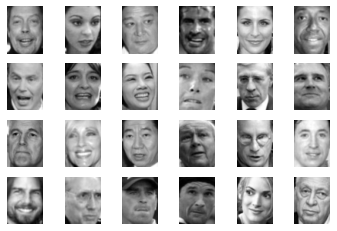

In [12]:
# 顯示正樣本部份圖片
fig, ax = plt.subplots(4,6)
for i, axi in enumerate(ax.flat):
    axi.imshow(positive_patches[500 * i], cmap='gray')
    axi.axis('off')

In [13]:
from skimage import data, transform, color

imgs_to_use = ['hubble_deep_field', 'text', 'coins', 'moon',
               'page', 'clock','coffee','chelsea','horse']
images = [color.rgb2gray(getattr(data, name)())
          for name in imgs_to_use]
len(images)

<ipython-input-13-8f66249471cd>:5: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
  images = [color.rgb2gray(getattr(data, name)())


9

In [14]:
from sklearn.feature_extraction.image import PatchExtractor

In [15]:
def extract_patches(img, N, scale = 1.0, patch_size = positive_patches[0].shape):
    extracted_patch_size = tuple((scale * np.array(patch_size)).astype(int))
    extractor = PatchExtractor(patch_size=extracted_patch_size,
                               max_patches=N, random_state=0)
    patches = extractor.transform(img[np.newaxis])
    if scale != 1:
        patches = np.array([transform.resize(patch, patch_size)
                            for patch in patches])
    return patches

In [16]:
negative_patches = np.vstack([extract_patches(im, 1000, scale)
                              for im in images for scale in [0.5, 1.0, 2.0]])
negative_patches.shape

(27000, 62, 47)

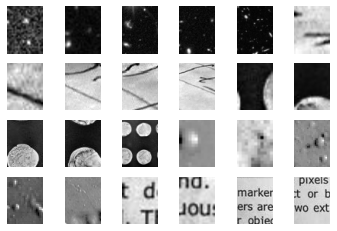

In [20]:
# 顯示部份負樣本
fig, ax = plt.subplots(4,6)
for i, axi in enumerate(ax.flat):
    axi.imshow(negative_patches[600 * i], cmap='gray')
    axi.axis('off')

In [21]:
from skimage import feature   # To use skimage.feature.hog()
from itertools import chain

X_train = np.array([feature.hog(im)
                    for im in chain(positive_patches,
                                    negative_patches)])
y_train = np.zeros(X_train.shape[0])
y_train[:positive_patches.shape[0]] = 1

In [22]:
# 使用 SVM 作二分類的訓練
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV 

# C為矯正過度擬合強度的倒數，使用 GridSearchCV 尋求最佳參數值
grid = GridSearchCV(LinearSVC(dual=False), {'C': [1.0, 2.0, 4.0, 8.0]},cv=3)
grid.fit(X_train, y_train)
grid.best_score_

0.9875226803867472

In [23]:
grid.best_params_ 


{'C': 1.0}

In [24]:
# 依最佳參數值再訓練一次
model = grid.best_estimator_
model.fit(X_train, y_train)

LinearSVC(dual=False)

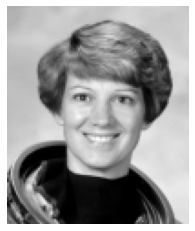

In [25]:
test_img = data.astronaut()
test_img = color.rgb2gray(test_img)
test_img = transform.rescale(test_img, 0.5)
test_img = test_img[:120, 60:160]


plt.imshow(test_img, cmap='gray')
plt.axis('off');

In [18]:
def sliding_window(img, patch_size=positive_patches[0].shape,
                   istep=2, jstep=2, scale=1.0):
    Ni, Nj = (int(scale * s) for s in patch_size)
    for i in range(0, img.shape[0] - Ni, istep):
        for j in range(0, img.shape[1] - Ni, jstep):
            patch = img[i:i + Ni, j:j + Nj]
            if scale != 1:
                patch = transform.resize(patch, patch_size)
            yield (i, j), patch

In [26]:
indices, patches = zip(*sliding_window(test_img))
patches_hog = np.array([feature.hog(patch) for patch in patches])

# 辨識每一視窗
labels = model.predict(patches_hog)
labels.sum() 

55.0

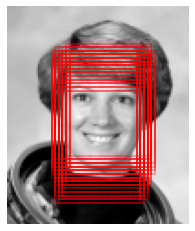

In [27]:
# 將每一個偵測到的視窗顯示出來
fig, ax = plt.subplots()
ax.imshow(test_img, cmap='gray')
ax.axis('off')

# 取得左上角座標
Ni, Nj = positive_patches[0].shape
indices = np.array(indices)

# 顯示
for i, j in indices[labels == 1]:
    ax.add_patch(plt.Rectangle((j, i), Nj, Ni, edgecolor='red',
                               alpha=0.3, lw=2, facecolor='none'))

In [28]:
patches_hog.shape


(551, 1215)

In [29]:
candidate_patches = patches_hog[labels == 1]
candidate_patches.shape

(55, 1215)

In [34]:
def non_max_suppression_slow(boxes, overlapthresh = 0.5):
    if len(boxes) == 0:
        return []
    pick = []
    x1 = boxes[:, 0]
    y1 = boxes[:, 1]
    x2 = boxes[:, 2]
    y2 = boxes[:, 3]
    
    area = (x2 - x1 + 1) * (y2 - y1 + 1)
    idxs = np.argsort(y2)
    
    while len(idxs) > 0:
        last = len(idxs) - 1
        i = idxs[last]
        pick.append(i)
        suppress = [last]
        for pos in range(0, last):
            j = idxs[pos]
            xx1 = max(x1[i], x1[j])
            yy1 = max(y1[i], y1[j])
            xx2 = min(x2[i], x2[j])
            yy2 = min(y2[i], y2[j])
            w = max(0, xx2 - xx1 + 1)
            h = max(0, yy2 - yy1 + 1)
            overlap = float(w * h) / area[j]
            if overlap > overlapthresh:
                suppress.append(pos)
        idxs = np.delete(idxs, suppress)
        
    return boxes[pick]

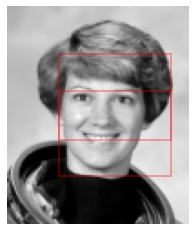

In [36]:
candidate_boxes = []
for i, j in indices[labels == 1]:
    candidate_boxes.append([j, i, Nj, Ni])
final_boxes = non_max_suppression_slow(np.array(candidate_boxes).reshape(-1, 4))
fig, ax = plt.subplots()
ax.imshow(test_img, cmap='gray')
ax.axis('off')

# 顯示
for i, j, Ni, Nj in final_boxes:
    ax.add_patch(plt.Rectangle((i, j), Ni, Nj, edgecolor='red',
                               alpha=0.3, lw=2, facecolor = 'none'))

In [38]:
import torch 
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms
import numpy as np
import time
import cv2

In [39]:
WIDTH = 600
PYR_SCALE = 1.5
WIN_STEP = 16
ROI_SIZE = (250, 250)
INPUT_SIZE = (224, 224)

In [40]:
device = "cpu"

In [43]:
model = models.resnet50(pretrained = True).to(device)

In [44]:
from PIL import Image

In [45]:
filename = './images_Object_Detection/bike.jpg'

In [48]:
orig = Image.open(filename)
orig = orig.resize((WIDTH, int(orig.size[1] / orig.size[0] * WIDTH)))

In [50]:
Width_Height_ratio = orig.size[1] / orig.size[0]
orig.size

(600, 400)

In [51]:
def sliding_window(image, step, ws):
    for y in range(0, image.size[1] - ws[1], step):
        for x in range(0, image.size[0] - ws[0], step):
            yield (x, y, image.crop((x, y, x + ws[0], y + ws[1])))

In [52]:
def image_pyramid(image, scale = 1.5, minsize = (224, 224)):
    yield image
    
    while True:
        w = int(image.size[0] / scale)
        image = image.resize((w, int(Width_Height_ratio * w)))
        if image.size[0] < minsize[1] or image.size[1] < minsize[0]:
            break
        yield image

In [93]:
transform = transforms.Compose([
    transforms.Resize(INPUT_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.485, 0.456, 0.406],
                        std = [0.229, 0.224, 0.225])
])
def PIL2CV2(orig):
    pil_image = orig.copy()
    open_cv_image = np.array(pil_image)
    return open_cv_image[:, :, ::-1].copy()

In [60]:
pyramid = image_pyramid(orig, scale = PYR_SCALE, minsize = ROI_SIZE)
rois = torch.tensor([])
locs = []
for image in pyramid:
    scale = WIDTH / float(image.size[0])
    print(image.size, 1/scale)
    
    for (x, y, roiOrig) in sliding_window(image, WIN_STEP, ROI_SIZE):
        x = int(x * scale)
        y = int(y * scale)
        w = int(ROI_SIZE[0] * scale)
        h = int(ROI_SIZE[0] * scale)
        
        roi = transform(roiOrig)
        roi = roi.unsqueeze(0)
        
        if len(roi.shape) == 1:
            rois = roi
        else:
            rois = torch.cat((rois, roi), dim = 0)
        locs.append((x, y, x + w, y + h))
                    
rois = rois.to(device)

(600, 400) 1.0
(400, 266) 0.6666666666666666


In [61]:
print(locs)

[(0, 0, 250, 250), (16, 0, 266, 250), (32, 0, 282, 250), (48, 0, 298, 250), (64, 0, 314, 250), (80, 0, 330, 250), (96, 0, 346, 250), (112, 0, 362, 250), (128, 0, 378, 250), (144, 0, 394, 250), (160, 0, 410, 250), (176, 0, 426, 250), (192, 0, 442, 250), (208, 0, 458, 250), (224, 0, 474, 250), (240, 0, 490, 250), (256, 0, 506, 250), (272, 0, 522, 250), (288, 0, 538, 250), (304, 0, 554, 250), (320, 0, 570, 250), (336, 0, 586, 250), (0, 16, 250, 266), (16, 16, 266, 266), (32, 16, 282, 266), (48, 16, 298, 266), (64, 16, 314, 266), (80, 16, 330, 266), (96, 16, 346, 266), (112, 16, 362, 266), (128, 16, 378, 266), (144, 16, 394, 266), (160, 16, 410, 266), (176, 16, 426, 266), (192, 16, 442, 266), (208, 16, 458, 266), (224, 16, 474, 266), (240, 16, 490, 266), (256, 16, 506, 266), (272, 16, 522, 266), (288, 16, 538, 266), (304, 16, 554, 266), (320, 16, 570, 266), (336, 16, 586, 266), (0, 32, 250, 282), (16, 32, 266, 282), (32, 32, 282, 282), (48, 32, 298, 282), (64, 32, 314, 282), (80, 32, 330, 

In [67]:
with open("imagenet_classes.txt", "r") as f:
    categories = [s.strip() for s in f.readlines()]


In [69]:
model.eval()
with torch.no_grad():
    output = model(rois)
probabilities = torch.nn.functional.softmax(output, dim = 1)
top_prob, top_catid = torch.topk(probabilities, 1)
probabilities

tensor([[1.1459e-09, 1.1758e-09, 1.2394e-09,  ..., 5.5235e-10, 1.5410e-08,
         2.7375e-09],
        [5.8599e-09, 3.2778e-09, 3.7887e-09,  ..., 1.4363e-09, 3.6072e-08,
         4.8168e-09],
        [5.6025e-09, 2.6297e-09, 5.6039e-09,  ..., 7.2886e-10, 2.2313e-08,
         3.9351e-09],
        ...,
        [2.5592e-07, 8.3919e-07, 4.4335e-07,  ..., 3.6762e-07, 4.9970e-05,
         5.5935e-06],
        [3.8170e-07, 2.0160e-06, 6.7205e-07,  ..., 8.1094e-07, 8.3413e-05,
         7.8072e-06],
        [8.3064e-08, 4.2997e-07, 1.2685e-07,  ..., 1.4579e-07, 2.6342e-05,
         4.5254e-06]])

In [70]:
probabilities[0, 518]


tensor(0.7592)

In [71]:
torch.topk(probabilities[202], 1)

torch.return_types.topk(
values=tensor([0.5963]),
indices=tensor([671]))

In [72]:
top_catid.numpy().reshape(-1)


array([518, 518, 518, 518, 518, 444, 671, 444, 444, 671, 444, 671, 671,
       671, 671, 671, 671, 671, 671, 444, 671, 444, 444, 444, 444, 444,
       444, 444, 444, 444, 444, 444, 444, 444, 444, 444, 444, 444, 444,
       444, 444, 444, 444, 444, 444, 444, 444, 444, 444, 444, 444, 444,
       444, 444, 444, 444, 444, 518, 444, 444, 671, 444, 444, 444, 444,
       444, 518, 444, 444, 444, 518, 518, 671, 444, 444, 444, 444, 444,
       518, 671, 671, 444, 671, 671, 444, 444, 444, 444, 518, 518, 518,
       518, 671, 518, 518, 444, 444, 444, 444, 444, 671, 518, 518, 671,
       671, 671, 444, 444, 444, 444, 518, 518, 671, 518, 671, 518, 518,
       444, 444, 444, 444, 444, 671, 518, 518, 444, 671, 671, 444, 444,
       444, 444, 444, 671, 671, 518, 671, 518, 671, 444, 671, 444, 444,
       671, 671, 671, 444, 671, 671, 671, 444, 444, 444, 444, 518, 518,
       671, 444, 671, 518, 518, 444, 444, 444, 444, 444, 671, 518, 671,
       671, 671, 671, 444, 444, 444, 444, 671, 671, 671, 518, 51

In [73]:
for i in range(probabilities.shape[0]):
    print(i, probabilities[i, 671].item())

0 0.02923380769789219
1 0.08460104465484619
2 0.04576577618718147
3 0.09883072972297668
4 0.19614671170711517
5 0.2771822512149811
6 0.42327040433883667
7 0.21719513833522797
8 0.24911850690841675
9 0.5417363047599792
10 0.4414781928062439
11 0.5151090025901794
12 0.6429325938224792
13 0.5351095795631409
14 0.7407360672950745
15 0.5671417117118835
16 0.7474364638328552
17 0.7511429786682129
18 0.43229466676712036
19 0.3962024450302124
20 0.37087282538414
21 0.3517274558544159
22 0.0830259621143341
23 0.10250932723283768
24 0.08064674586057663
25 0.04198562353849411
26 0.04752030223608017
27 0.14077644050121307
28 0.14167825877666473
29 0.03401259332895279
30 0.19582192599773407
31 0.061061836779117584
32 0.14424847066402435
33 0.1798928678035736
34 0.2927479147911072
35 0.38323017954826355
36 0.13987697660923004
37 0.18156617879867554
38 0.21003316342830658
39 0.3091208338737488
40 0.20443470776081085
41 0.05255598574876785
42 0.11210418492555618
43 0.1489470899105072
44 0.291979074478

In [74]:
MIN_CONFIDENCE = 0.4
labels = {}
for (i, p) in enumerate(zip(top_prob.numpy().reshape(-1), top_catid.numpy().reshape(-1))):
    (prob, imagenetID) = p
    label = categories[imagenetID]
    
    if prob >= MIN_CONFIDENCE:
        if imagenetID != 671: continue
        box = locs[i]
        L = labels.get(label, [])
        L.append((box, prob))
        labels[label] = L
labels.keys()

dict_keys(['mountain bike'])

In [77]:
labels['mountain bike']

[((96, 0, 346, 250), 0.4232704),
 ((144, 0, 394, 250), 0.5417363),
 ((176, 0, 426, 250), 0.515109),
 ((192, 0, 442, 250), 0.6429326),
 ((208, 0, 458, 250), 0.5351096),
 ((224, 0, 474, 250), 0.74073607),
 ((240, 0, 490, 250), 0.5671417),
 ((256, 0, 506, 250), 0.74743646),
 ((272, 0, 522, 250), 0.751143),
 ((288, 0, 538, 250), 0.43229467),
 ((256, 32, 506, 282), 0.49725762),
 ((96, 48, 346, 298), 0.4178788),
 ((224, 48, 474, 298), 0.4782079),
 ((256, 48, 506, 298), 0.66529185),
 ((272, 48, 522, 298), 0.53838515),
 ((64, 64, 314, 314), 0.45232227),
 ((192, 64, 442, 314), 0.46591482),
 ((240, 64, 490, 314), 0.4065386),
 ((256, 64, 506, 314), 0.46801832),
 ((272, 64, 522, 314), 0.59752214),
 ((32, 80, 282, 330), 0.4887967),
 ((64, 80, 314, 330), 0.5536174),
 ((192, 80, 442, 330), 0.41802257),
 ((256, 80, 506, 330), 0.51819736),
 ((272, 80, 522, 330), 0.64278394),
 ((16, 96, 266, 346), 0.5096433),
 ((32, 96, 282, 346), 0.47962782),
 ((64, 96, 314, 346), 0.51634854),
 ((96, 96, 346, 346), 0.4

In [95]:
def nms_pytorch(P, thresh_iou):
    x1 = P[:, 0]
    y1 = P[:, 1]
    x2 = P[:, 2]
    y2 = P[:, 3]
    
    scores = P[:, 4]
    areas = (x2 - x1) * (y2 - y1)
    order = scores.argsort()
    
    keep = []
    while len(order) > 0:
        idx = order[-1]
        order = order[:-1]
        if len(order) == 0:
            break
        xx1 = torch.index_select(x1, dim = 0, index = order)
        xx2 = torch.index_select(x2, dim = 0, index = order)
        yy1 = torch.index_select(y1, dim = 0, index = order)
        yy2 = torch.index_select(y2, dim = 0, index = order)
        
        xx1 = torch.max(xx1, x1[idx])
        yy1 = torch.max(yy1, y1[idx])
        xx2 = torch.min(xx2, x2[idx])
        yy2 = torch.min(yy2, y2[idx])
        
        w = xx2 - xx1
        h = yy2 - yy1
        
        w = torch.clamp(w, min = .0)
        h = torch.clamp(h, min = .0)
        
        inter = w*h
        rem_areas = torch.index_select(areas, dim = 0, index = order) 
        union = (rem_areas - inter) + areas[idx]
        IoU = inter / union
        mask = IoU < thresh_iou
        order = order[mask]
    return keep

In [100]:
for label in labels.keys():
    open_cv_image = PIL2CV2(orig)
    
    for (box, prob) in labels[label]:
        (startX, startY, endX, endY) = box
        cv2.rectangle(open_cv_image, (startX, startY), (endX, endY),
            (0, 255, 0), 2)
    cv2.imshow("Before NMS", open_cv_image)
    
    open_cv_image2 = PIL2CV2(orig)
    boxes = np.array([p[0] for p in labels[label]])
    proba = np.array([p[1] for p in labels[label]])
    boxes = non_max_suppression_slow(boxes, MIN_CONFIDENCE)
    color_list=[(0, 255, 0), (255, 0, 0), (255, 255, 0), (0, 0, 0), (0, 255, 255)]
    cv2.rectangle(open_cv_image2, (int(startX), int(startY)), (int(endX), int(endY))
                      , color_list[i%len(color_list)], 2)
    startY = startY - 15 if startY - 15 > 0 else startY + 15
    cv2.putText(open_cv_image2, str(label), (int(startX), int(startY)),
            cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0, 0, 255), 2)
    cv2.imshow("After NMS", open_cv_image2)
    cv2.waitKey(0)
            
cv2.destroyAllWindows()


In [101]:
boxes

array([[256, 144, 506, 394],
       [ 32, 144, 282, 394],
       [ 96,   0, 471, 375]])

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms
import numpy as np
import time
import cv2

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
"cuda" if torch.cuda.is_available() else "cpu"

'cuda'

In [4]:
device = "cpu"

In [5]:
WIDTH = 600
INPUT_SIZE = (224, 224)

In [6]:
model = models.resnet50(pretrained = True).to(device)

In [7]:
from PIL import Image

filename = './images_Object_Detection/bike.jpg'
orig = Image.open(filename)
# 等比例縮放圖片
orig = orig.resize((WIDTH, int(orig.size[1] / orig.size[0] * WIDTH)))
Width_Height_ratio = orig.size[1] / orig.size[0]
orig.size

(600, 400)

In [8]:
transform = transforms.Compose([
    transforms.Resize(INPUT_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.485, 0.456, 0.406],
                        std = [0.229, 0.224, 0.225])
])

In [33]:
def PIL2CV2(orig):
    pil_image = orig.copy()
    open_cv_image = np.array(pil_image)
    return open_cv_image[:, :, ::-1].copy()

In [10]:
import matplotlib.pyplot as plt

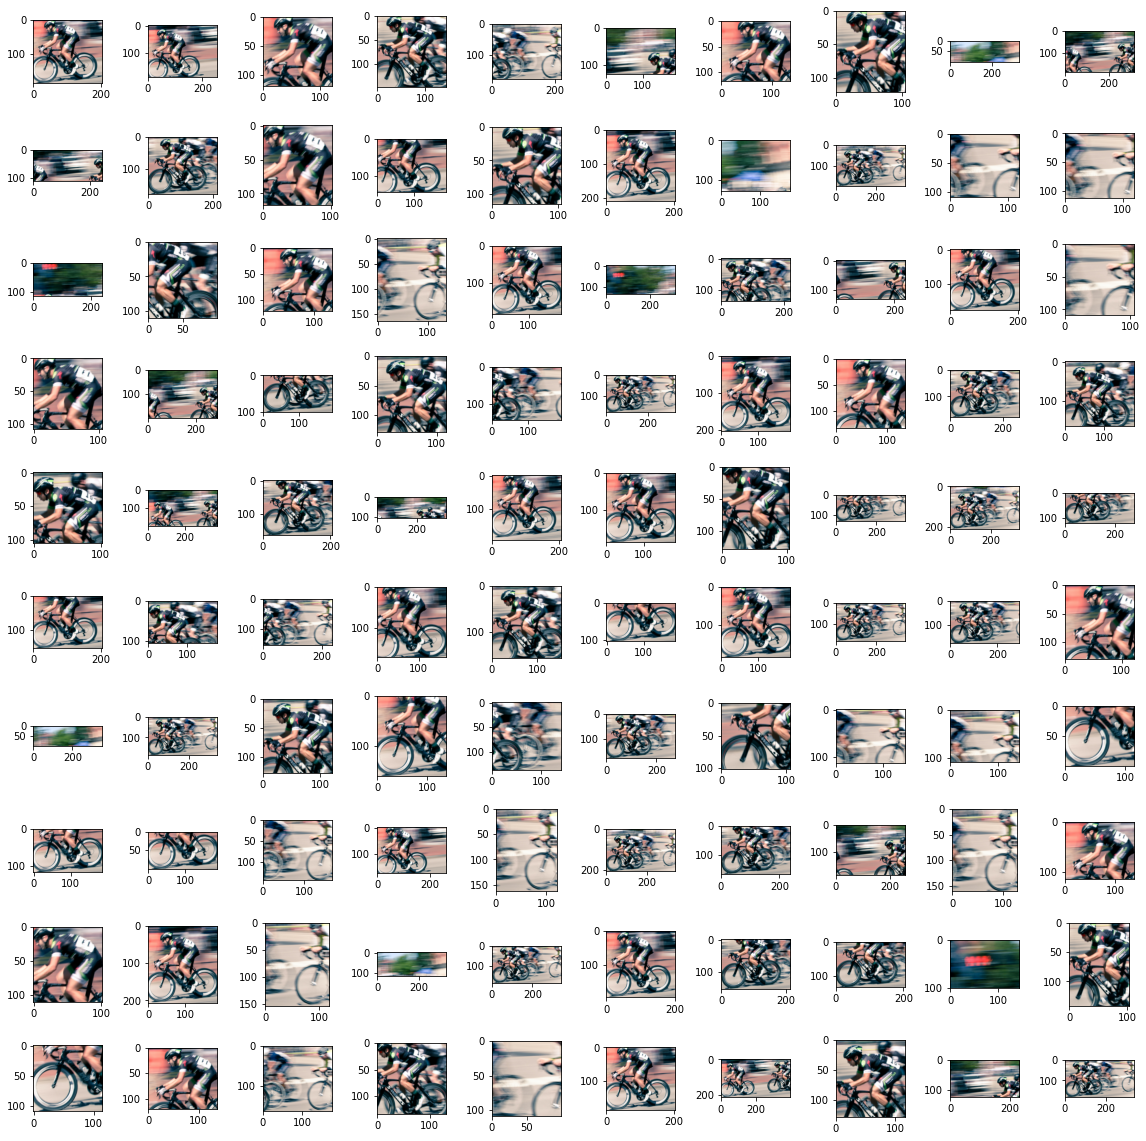

In [13]:
plt.figure(figsize = (16, 16))
def Selective_Search(img_path):
    img = cv2.imread(img_path)
    img = cv2.resize(img, (WIDTH, int(orig.size[1] / orig.size[0] * WIDTH)),
                    interpolation = cv2.INTER_AREA)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    cv2.setUseOptimized(True)
    cv2.setNumThreads(16)
    gs = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
    gs.setBaseImage(img)
    gs.switchToSelectiveSearchFast()
    rects = gs.process()
    
    rois = torch.tensor([])
    locs = []
    j = 1
    for i in range(len(rects)):
        x, y, w, h = rects[i]
        if w < 100 or w > 400 or h < 100: continue
            
        scale = WIDTH / float(w)
        
        crop_img = img[y : y + h, x : x + w]
        crop_img = Image.fromarray(crop_img)
        if j <= 100:
            plt.subplot(10, 10, j)
            plt.imshow(crop_img)
        j += 1
        roi = transform(crop_img)
        roi = roi.unsqueeze(0)
        
        if len(rois.shape) == 1:
            rois = roi
        else:
            rois = torch.cat((rois, roi), dim = 0)
        locs.append((x, y, x + w, y + h))
    return rois.to(device), locs
rois, locs = Selective_Search(filename)
plt.tight_layout()

In [14]:
rois.shape


torch.Size([239, 3, 224, 224])

In [15]:
len(locs)


239

In [16]:
locs


[(0, 141, 205, 328),
 (0, 126, 254, 316),
 (14, 143, 134, 263),
 (280, 135, 424, 283),
 (381, 106, 600, 281),
 (185, 65, 375, 192),
 (0, 144, 136, 263),
 (284, 137, 388, 259),
 (268, 0, 600, 100),
 (63, 76, 377, 262),
 (86, 104, 331, 213),
 (262, 125, 476, 304),
 (34, 145, 136, 263),
 (19, 174, 205, 316),
 (284, 137, 388, 253),
 (0, 128, 205, 337),
 (424, 0, 600, 128),
 (260, 106, 600, 305),
 (463, 146, 582, 254),
 (463, 138, 583, 250),
 (0, 33, 242, 148),
 (334, 147, 434, 257),
 (0, 141, 134, 263),
 (463, 116, 600, 281),
 (0, 145, 187, 329),
 (0, 0, 320, 131),
 (284, 125, 503, 259),
 (122, 126, 357, 256),
 (0, 152, 203, 329),
 (481, 141, 587, 250),
 (31, 145, 137, 254),
 (86, 62, 375, 262),
 (262, 203, 452, 304),
 (284, 125, 400, 253),
 (363, 132, 553, 278),
 (262, 123, 598, 304),
 (0, 125, 186, 328),
 (0, 141, 134, 276),
 (260, 125, 522, 305),
 (280, 119, 455, 283),
 (300, 125, 403, 231),
 (0, 76, 375, 271),
 (262, 141, 466, 303),
 (102, 73, 451, 179),
 (0, 145, 205, 337),
 (0, 141, 

In [17]:
with open("imagenet_classes.txt", "r") as f:
    categories = [s.strip() for s in f.readlines()]

In [18]:
model.eval()
with torch.no_grad():
    output = model(rois)
    
probabilities = torch.nn.functional.softmax(output, dim = 1)

top_prob, top_catid = torch.topk(probabilities, 1)
probabilities

tensor([[6.7859e-08, 6.4584e-08, 6.5515e-08,  ..., 1.0424e-07, 6.7446e-06,
         1.6081e-06],
        [1.0601e-08, 2.5583e-08, 6.2526e-08,  ..., 7.5671e-09, 1.2876e-06,
         6.0998e-07],
        [5.8235e-11, 2.6484e-11, 1.0763e-09,  ..., 3.2680e-11, 3.1007e-09,
         2.5492e-10],
        ...,
        [5.9021e-08, 5.6651e-07, 3.0300e-07,  ..., 6.4890e-08, 1.2721e-05,
         2.6267e-05],
        [1.1997e-09, 9.7925e-10, 2.3551e-09,  ..., 7.2801e-10, 7.0702e-08,
         2.1001e-08],
        [2.0298e-10, 2.9572e-10, 1.0192e-09,  ..., 1.0875e-10, 3.1424e-08,
         4.6873e-08]])

In [21]:
top_catid.numpy().reshape(-1)

array([671, 671, 444, 671, 444, 518, 444, 444, 518, 444, 518, 671, 444,
       444, 444, 671, 573, 444, 444, 880, 468, 671, 444, 444, 671, 829,
       444, 444, 671, 444, 444, 444, 671, 444, 671, 671, 671, 444, 671,
       671, 444, 444, 671, 670, 671, 671, 671, 444, 444, 444, 671, 444,
       444, 671, 671, 671, 671, 671, 671, 444, 518, 671, 444, 671, 518,
       671, 671, 444, 444, 671, 671, 671, 444, 671, 444, 671, 444, 444,
       444, 444, 444, 671, 444, 518, 671, 671, 671, 671, 920, 671, 444,
       444, 444, 671, 444, 671, 444, 444, 518, 444, 829, 671, 444, 444,
       444, 671, 671, 444, 870, 444, 671, 444, 671, 671, 829, 671, 671,
       671, 444, 444, 444, 671, 444, 671, 444, 518, 444, 518, 444, 671,
       444, 671, 444, 671, 920, 444, 671, 671, 444, 671, 444, 444, 444,
       671, 518, 518, 444, 444, 444, 444, 518, 518, 444, 444, 444, 671,
       671, 518, 670, 444, 444, 671, 671, 444, 671, 518, 829, 518, 444,
       671, 444, 671, 518, 880, 444, 444, 870, 671, 444, 671, 51

In [22]:
for i in range(probabilities.shape[0]):
    print(i, probabilities[i, 671].item())

0 0.600712239742279
1 0.3726586103439331
2 0.06142958998680115
3 0.8282459378242493
4 0.03157719597220421
5 0.05166376009583473
6 0.057377733290195465
7 0.4165581166744232
8 0.004511323291808367
9 0.022914543747901917
10 0.06410104036331177
11 0.8462012410163879
12 0.012276871129870415
13 0.4135500490665436
14 0.45633313059806824
15 0.6781032681465149
16 0.004296461585909128
17 0.24519245326519012
18 0.1197662428021431
19 0.04560251533985138
20 0.0032090628519654274
21 0.6866732835769653
22 0.21759875118732452
23 0.012988247908651829
24 0.8764978647232056
25 0.009654626250267029
26 0.3068253993988037
27 0.019846152514219284
28 0.6066382527351379
29 0.15461891889572144
30 0.07663443684577942
31 0.06848364323377609
32 0.6360558867454529
33 0.11857754737138748
34 0.3880065381526947
35 0.46142125129699707
36 0.8467355966567993
37 0.33575713634490967
38 0.4828374981880188
39 0.7925108075141907
40 0.09108598530292511
41 0.09773516654968262
42 0.6865461468696594
43 0.008660830557346344
44 0.5

In [23]:
probabilities[0, 671]


tensor(0.6007)

In [29]:
MIN_CONFIDENCE = 0.4
labels = {}
for (i, p) in enumerate(zip(top_prob.numpy().reshape(-1), 
                            top_catid.numpy().reshape(-1))):
    (prob, imagenetID) = p
    label = categories[imagenetID]
    
    if prob >= MIN_CONFIDENCE:
        if imagenetID != 671: continue
        box = locs[i]
        print(i, imagenetID)
        L = labels.get(label, [])
        L.append((box, prob))
        labels[label] = L

labels.keys()          

0 671
3 671
11 671
15 671
21 671
24 671
28 671
32 671
35 671
36 671
38 671
39 671
42 671
44 671
45 671
46 671
50 671
53 671
54 671
55 671
56 671
57 671
58 671
61 671
63 671
65 671
66 671
69 671
70 671
71 671
73 671
75 671
81 671
84 671
85 671
86 671
87 671
89 671
93 671
95 671
101 671
105 671
106 671
110 671
112 671
113 671
115 671
116 671
117 671
121 671
123 671
129 671
131 671
133 671
136 671
137 671
139 671
143 671
155 671
156 671
161 671
162 671
164 671
169 671
171 671
177 671
179 671
181 671
182 671
193 671
194 671
195 671
196 671
198 671
200 671
204 671
209 671
211 671
214 671
216 671
217 671
218 671
219 671
221 671
226 671
229 671
230 671
231 671
233 671
235 671
237 671


dict_keys(['mountain bike'])

In [30]:
labels['mountain bike']

[((0, 141, 205, 328), 0.60071224),
 ((280, 135, 424, 283), 0.82824594),
 ((262, 125, 476, 304), 0.84620124),
 ((0, 128, 205, 337), 0.67810327),
 ((334, 147, 434, 257), 0.6866733),
 ((0, 145, 187, 329), 0.87649786),
 ((0, 152, 203, 329), 0.60663825),
 ((262, 203, 452, 304), 0.6360559),
 ((262, 123, 598, 304), 0.46142125),
 ((0, 125, 186, 328), 0.8467356),
 ((260, 125, 522, 305), 0.4828375),
 ((280, 119, 455, 283), 0.7925108),
 ((262, 141, 466, 303), 0.68654615),
 ((0, 145, 205, 337), 0.52065915),
 ((0, 141, 186, 328), 0.7875094),
 ((300, 142, 404, 270), 0.71621835),
 ((0, 174, 205, 328), 0.6520177),
 ((20, 145, 187, 316), 0.8300183),
 ((280, 125, 432, 283), 0.8556974),
 ((0, 225, 185, 328), 0.6446171),
 ((0, 141, 185, 328), 0.78991634),
 ((262, 123, 600, 307), 0.46522182),
 ((260, 125, 553, 303), 0.46678573),
 ((262, 117, 600, 304), 0.46091515),
 ((0, 168, 139, 329), 0.5734791),
 ((262, 125, 538, 304), 0.6982059),
 ((267, 176, 373, 278), 0.5523019),
 ((0, 228, 115, 328), 0.42233837),
 (

In [37]:
def non_max_suppression_slow(boxes, overlapThresh = 0.5):
    if len(boxes) == 0:
        return []
    
    pick = []
    x1 = boxes[:, 0]
    y1 = boxes[:, 1]
    x2 = boxes[:, 2]
    y2 = boxes[:, 3]
    
    area = (x2 - x1 + 1) * (y2 - y1 + 1)
    idxs = np.argsort(y2)
    
    while len(idxs) > 0:
        last = len(idxs) - 1
        i = idxs[last]
        pick.append(i)
        suppress = [last]
        for pos in range(0, last):
            j = idxs[pos]
            xx1 = max(x1[i], x1[j])
            yy1 = max(y1[i], y1[j])
            xx2 = min(x2[i], x2[j])
            yy2 = min(y2[i], y2[j])
            w = max(0, xx2 - xx1 + 1)
            h = max(0, yy2 - yy1 + 1)
            
            overlap = float(w * h) / area[j]
            if overlap > overlapThresh:
                suppress.append(pos)
                
        # 刪除合格的視窗，繼續比對
        idxs = np.delete(idxs, suppress)
        
    # 傳回合格的視窗
    return boxes[pick]

In [ ]:
for label in labels.keys():
    open_cv_image = PIL2CV2(orig)
    
    for (box, prob) in labels[label]:
        (startX, startY, endX, endY) = box
        cv2.rectangle(open_cv_image, (startX, startY), (endX, endY),
            (0, 255, 0), 2)
    cv2.imshow('before NMS', open_cv_image)
    open_cv_image2 = PIL2CV2(orig) 
    boxes = np.array([p[0] for p in labels[label]])
    proba = np.array([p[1] for p in labels[label]])
    boxes = non_max_suppression_slow(boxes, MIN_CONFIDENCE)
    
    color_list=[(0, 255, 0), (255, 0, 0), (255, 255, 0), (0, 0, 0), (0, 255, 255)]
    for i, x in enumerate(boxes):
        # startX, startY, endX, endY, label = x.numpy()
        startX, startY, endX, endY = x #.numpy()
        # 畫框及類別
        cv2.rectangle(open_cv_image2, (int(startX), int(startY)), (int(endX), int(endY))
                      , color_list[i%len(color_list)], 2)
        startY = startY - 15 if startY - 15 > 0 else startY + 15
        cv2.putText(open_cv_image2, str(label), (int(startX), int(startY)),
            cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0, 0, 255), 2)

    # 顯示
    cv2.imshow("After NMS", open_cv_image2)
    cv2.waitKey(0)
            
cv2.destroyAllWindows()